## Comment Classification using LSTM
We will be using the LSTM to classify the review comments. 


In [5]:
# Import Library
import random
import torch, torchtext
from torchtext.legacy import data 
import re
import spacy
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline
import seaborn as sns
# Manual Seed
SEED = 43
torch.manual_seed(SEED)

In [6]:
## Read the coments 
# The comments are of the form
# "commentId","prId","commentText","author","commentClassification"

import pandas as pd
df = pd.read_csv('data/comments_all.csv')

## we are considering only few types of the comments
#df=df[df['commentClassification'].isin(['LOGISTICS_SUGGESTION','BUGGYCODE_SUGGESTION','COMPLETENESS_SUGGESTION','REFACTORING_SUGGESTION','CODE_SUGGESTION'])]
df=df[df['commentClassification'].isin(['BUGGYCODE_SUGGESTION','REFACTORING_SUGGESTION','CODE_SUGGESTION','QUESTIONING',
                    'COMPLETENESS_SUGGESTION','LOGISTICS_SUGGESTION','LOGICAL_SUGGESTION','SPELLING_SUGGESTION',
                     'REUSE_SUGGESTION','DOCUMENTATION_SUGGESTION'])]
df=df.reset_index()
df.commentClassification.value_counts()

BUGGYCODE_SUGGESTION        988
REFACTORING_SUGGESTION      925
CODE_SUGGESTION             906
QUESTIONING                 545
COMPLETENESS_SUGGESTION     417
LOGISTICS_SUGGESTION        350
LOGICAL_SUGGESTION          316
SPELLING_SUGGESTION         217
REUSE_SUGGESTION             64
DOCUMENTATION_SUGGESTION     36
Name: commentClassification, dtype: int64

In [7]:
## define a tokeinzer that will be used to tokeinze the comments text
tok = spacy.load("en_core_web_sm")
def tokenizer (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

In [8]:
Comment = data.Field(sequential = True, tokenize = tokenizer, batch_first =False, include_lengths=True)
Label = data.LabelField(tokenize =tokenizer, is_target=True, batch_first =False, sequential =False)

fields = [('commentText', Comment),('commentClassification',Label)]


In [9]:
##converting the data in the form of comment,Label
example = [data.Example.fromlist([df.commentText[i],df.commentClassification[i]], fields) for i in range(df.shape[0])]
commentDataset = data.Dataset(example, fields)


In [10]:
## split the data into train, validation,test
(train, valid,test) = commentDataset.split(split_ratio=[0.90, 0.01,0.19], random_state=random.seed(SEED))
print(len(train), len(valid),len(test))

3898 823 43


In [11]:
##check the first training example
vars(train.examples[1])

{'commentText': ['what', 'does', '   ', 'means', ' '],
 'commentClassification': 'BUGGYCODE_SUGGESTION'}

In [12]:
## Convert the tokens to vectors and build a vocabulary..we are using the glove encoding
Comment.build_vocab(train, valid,test, vectors = "glove.6B.100d", unk_init = torch.Tensor.normal_)
Label.build_vocab(train)

In [13]:
print('Size of input vocab : ', len(Comment.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Comment.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  4357
Size of label vocab :  10
Top 10 words appreared repeatedly : [(' ', 5814), ('  ', 2972), ('the', 1942), ('   ', 1871), ('this', 1531), ('please', 1418), ('we', 1260), ('it', 1155), ('a', 1151), ('is', 1123)]
Labels :  defaultdict(None, {'BUGGYCODE_SUGGESTION': 0, 'REFACTORING_SUGGESTION': 1, 'CODE_SUGGESTION': 2, 'QUESTIONING': 3, 'COMPLETENESS_SUGGESTION': 4, 'LOGISTICS_SUGGESTION': 5, 'LOGICAL_SUGGESTION': 6, 'SPELLING_SUGGESTION': 7, 'REUSE_SUGGESTION': 8, 'DOCUMENTATION_SUGGESTION': 9})


In [14]:
## check for the gpu and use it if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
## create the iterators from the train, test , validation set
train_iterator, valid_iterator,test_iterator = data.BucketIterator.splits((train, valid,test), batch_size = 32, 
                                                            sort_key = lambda x: len(x.commentText),
                                                            sort_within_batch=True, device = device)

###  network definition

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,batch_first=False)
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        
    def forward(self, text, text_lengths):
        # text = [batch size, sent_length]
        
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]

        output, (hidden, cell) = self.encoder(embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)#...when the bidirectional is true..also the number of dimention dimention is left
        # Hidden = [batch size, hid dim * num directions]
        
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs, dim=1)
            
        return output

In [17]:
pretrained_embeddings = Comment.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([4357, 100])


In [18]:
# Define hyperparameters
size_of_vocab = len(Comment.vocab)
embedding_dim = 100
num_hidden_nodes = 100
num_output_nodes = 10
num_layers = 2
dropout = 0.2

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [19]:
## making use of the pretrained embeddings ..these are the glove trained embeddings
pretrained_embeddings = Comment.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.0166, -0.4668,  2.0909,  ..., -1.4692,  0.4476, -0.7223],
        [-0.0791, -0.2089, -0.3442,  ...,  0.4657,  0.6297, -1.7395],
        [ 1.6592, -0.1411, -1.2852,  ...,  1.6803, -0.7856, -0.8160],
        ...,
        [-0.2309, -0.4129,  0.2818,  ...,  0.5106, -0.4050,  0.5735],
        [-1.4407, -1.4629,  1.2226,  ..., -1.9031, -0.0889, -0.4963],
        [ 0.9829, -0.8564,  0.0730,  ..., -0.5304,  1.1437, -0.4599]])

In [20]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(4357, 100)
  (encoder): LSTM(100, 100, num_layers=2, dropout=0.2)
  (fc): Linear(in_features=200, out_features=10, bias=True)
)
The model has 599,310 trainable parameters


In [21]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

### the training loop

In [22]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        comment, comment_lengths = batch.commentText   
        
        # convert to 1D tensor
        predictions = model(comment, comment_lengths).squeeze()  
        
        # compute the loss
        loss = criterion(predictions, batch.commentClassification)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.commentClassification)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [23]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            comment, comment_lengths = batch.commentText
            
            # convert to 1d tensor
            predictions = model(comment, comment_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.commentClassification)
            acc = binary_accuracy(predictions, batch.commentClassification)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### training

In [24]:
N_EPOCHS = 20
best_valid_loss = float('inf')
tb=SummaryWriter()
training_stats = []

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    print(f'\t Epoch# {epoch}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')
    
    ## added to get the data in the tensorboard
    tb.add_scalar('Train Loss',train_loss,epoch)
    tb.add_scalar('Val Loss',valid_loss,epoch)
    tb.add_scalar('Train Accuracy',train_acc,epoch)
    tb.add_scalar('Val Accuracy',valid_acc,epoch)
    training_stats.append(
    {
        'epoch': epoch,
        'Train Loss': train_loss,
        'Valid Loss': valid_loss,
        'Train Accur':train_acc,
        'Valid Accur': valid_acc
        
    })
    
    
    ##TODO: GENERATE A GRAPH FOR THE TEST?TRAIN VALIDATION

	 Epoch# 0
	Train Loss: 2.255 | Train Acc: 21.75%
	 Val. Loss: 2.207 |  Val. Acc: 21.63% 

	 Epoch# 1
	Train Loss: 2.184 | Train Acc: 30.11%
	 Val. Loss: 2.141 |  Val. Acc: 36.49% 

	 Epoch# 2
	Train Loss: 2.113 | Train Acc: 35.66%
	 Val. Loss: 2.103 |  Val. Acc: 36.01% 

	 Epoch# 3
	Train Loss: 2.084 | Train Acc: 38.50%
	 Val. Loss: 2.087 |  Val. Acc: 37.57% 

	 Epoch# 4
	Train Loss: 2.069 | Train Acc: 39.82%
	 Val. Loss: 2.084 |  Val. Acc: 37.01% 

	 Epoch# 5
	Train Loss: 2.055 | Train Acc: 40.90%
	 Val. Loss: 2.070 |  Val. Acc: 39.03% 

	 Epoch# 6
	Train Loss: 2.044 | Train Acc: 42.06%
	 Val. Loss: 2.079 |  Val. Acc: 36.87% 

	 Epoch# 7
	Train Loss: 2.028 | Train Acc: 43.82%
	 Val. Loss: 2.074 |  Val. Acc: 38.07% 

	 Epoch# 8
	Train Loss: 2.022 | Train Acc: 44.30%
	 Val. Loss: 2.058 |  Val. Acc: 40.07% 

	 Epoch# 9
	Train Loss: 2.015 | Train Acc: 44.97%
	 Val. Loss: 2.067 |  Val. Acc: 38.62% 

	 Epoch# 10
	Train Loss: 2.005 | Train Acc: 46.06%
	 Val. Loss: 2.058 |  Val. Acc: 39.99% 

In [25]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Train Loss,Valid Loss,Train Accur,Valid Accur
epoch,,,,
0,2.25,2.21,0.22,0.22
1,2.18,2.14,0.30,0.36
2,2.11,2.10,0.36,0.36
3,2.08,2.09,0.38,0.38
4,2.07,2.08,0.40,0.37
5,2.05,2.07,0.41,0.39
6,2.04,2.08,0.42,0.37
7,2.03,2.07,0.44,0.38
8,2.02,2.06,0.44,0.40


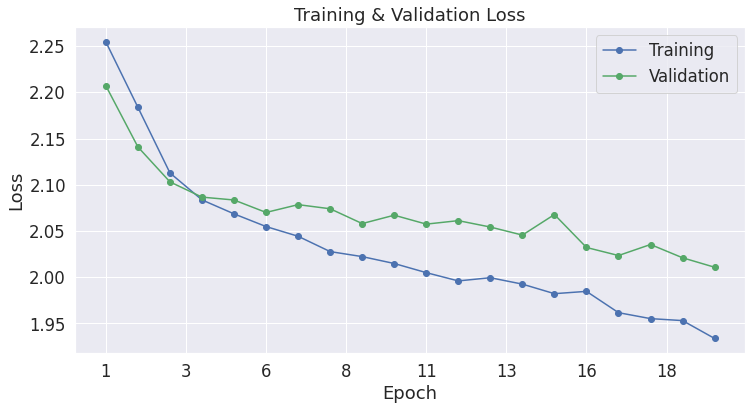

In [26]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')
# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Train Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x+1)))
plt.show()

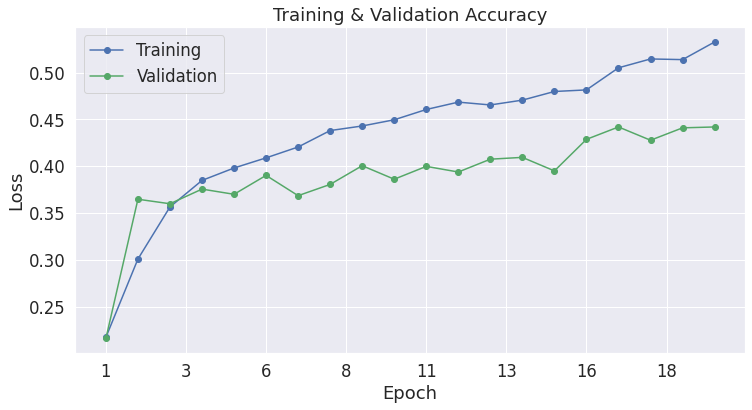

In [27]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')
# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Train Accur'], 'b-o', label="Training")
plt.plot(df_stats['Valid Accur'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x+1)))
plt.show()

In [22]:
## find the test accuracy of the model
model.load_state_dict(torch.load('saved_weights.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.899 | Test Acc: 56.07%
